In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##### Load model_df

In [2]:
model_df = pd.read_csv("../data/processed/model_clustered.csv")

In [3]:
model_df.tail()

,customer_id,city,signup_date,age,gender,total_trips,cancelled_trips,days_since_last_trip,churned,engagement_score,...,recency_days,app_open,ride_completed,ride_request,search,total_events_30d,promos_redeemed_30d,promo_cost_30d,avg_discount_value_30d,Cluster
2995,CUST02995,Milan,2025-08-07,20,Other,31,4,6,0,1.0,...,7.0,31.0,6.0,8.0,16.0,61.0,0.0,0.0,0.0,2
2996,CUST02996,Amsterdam,2023-08-25,24,Female,37,3,1,0,1.0,...,20.0,31.0,3.0,9.0,13.0,56.0,0.0,0.0,0.0,2
2997,CUST02997,London,2023-12-25,49,Male,44,4,21,0,1.0,...,13.0,22.0,6.0,9.0,15.0,52.0,0.0,0.0,0.0,2
2998,CUST02998,Barcelona,2025-04-28,60,Other,29,1,50,1,1.0,...,0.0,31.0,5.0,7.0,19.0,62.0,0.0,0.0,0.0,0
2999,CUST02999,London,2023-12-13,60,Other,50,7,22,1,1.0,...,10.0,31.0,7.0,11.0,14.0,63.0,0.0,0.0,0.0,2


#### Preprocessing

##### Encode Categorical Features

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
label_enc = LabelEncoder()
model_df["city"] = label_enc.fit_transform(model_df["city"])
model_df["gender"] = label_enc.fit_transform(model_df["gender"])
model_df["persona"] = label_enc.fit_transform(model_df["persona"])
model_df["signup_channel"] = label_enc.fit_transform(model_df["signup_channel"])
model_df["income_level"] = label_enc.fit_transform(model_df["income_level"])

###### Create correlation heatmap

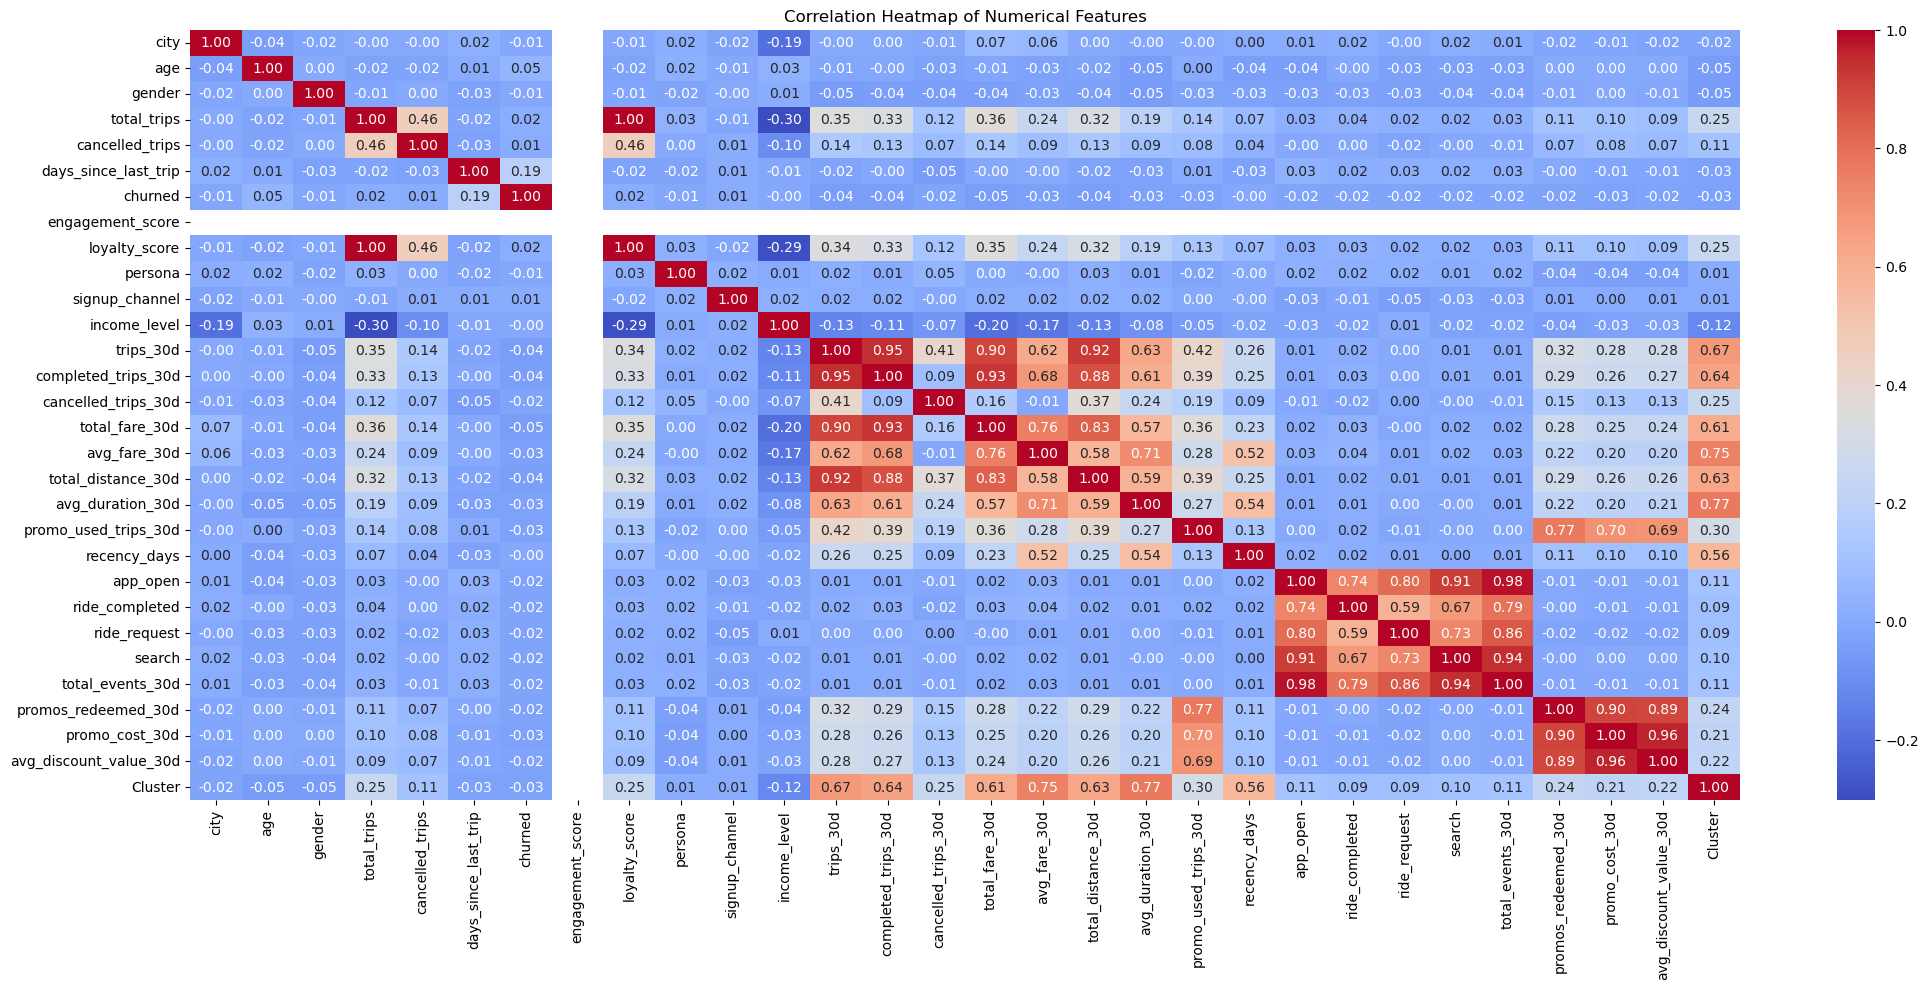

In [6]:
model_df.drop(["customer_id", "signup_date", "last_trip_date"], axis=1, inplace=True)

# Correlation matrix
corr_matrix = model_df.corr()

# Plot correlation heatmap

plt.figure(figsize=(25,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [7]:
target_col = "churned"

corr_with_target = (
    model_df.corr()[target_col]
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "feature", target_col: "correlation"})
)
corr_with_target.head(30)


,feature,correlation
0,churned,1.000000
1,days_since_last_trip,0.191969
2,age,0.048058
3,total_trips,0.015272
4,loyalty_score,0.015070
5,cancelled_trips,0.010992
6,signup_channel,0.009850
7,income_level,-0.001758
8,recency_days,-0.003788
9,city,-0.006671


###### Drop irrelevant features

In [8]:
model_df.drop(['cancelled_trips','engagement_score', 'loyalty_score',
       'promo_cost_30d','app_open', 'ride_completed',
       'ride_request', 'search', 'promos_redeemed_30d','avg_discount_value_30d'], axis=1, inplace=True)

In [9]:
model_df.columns

Index(['city', 'age', 'gender', 'total_trips', 'days_since_last_trip',
       'churned', 'persona', 'signup_channel', 'income_level', 'trips_30d',
       'completed_trips_30d', 'cancelled_trips_30d', 'total_fare_30d',
       'avg_fare_30d', 'total_distance_30d', 'avg_duration_30d',
       'promo_used_trips_30d', 'recency_days', 'total_events_30d', 'Cluster'],
      dtype='object')

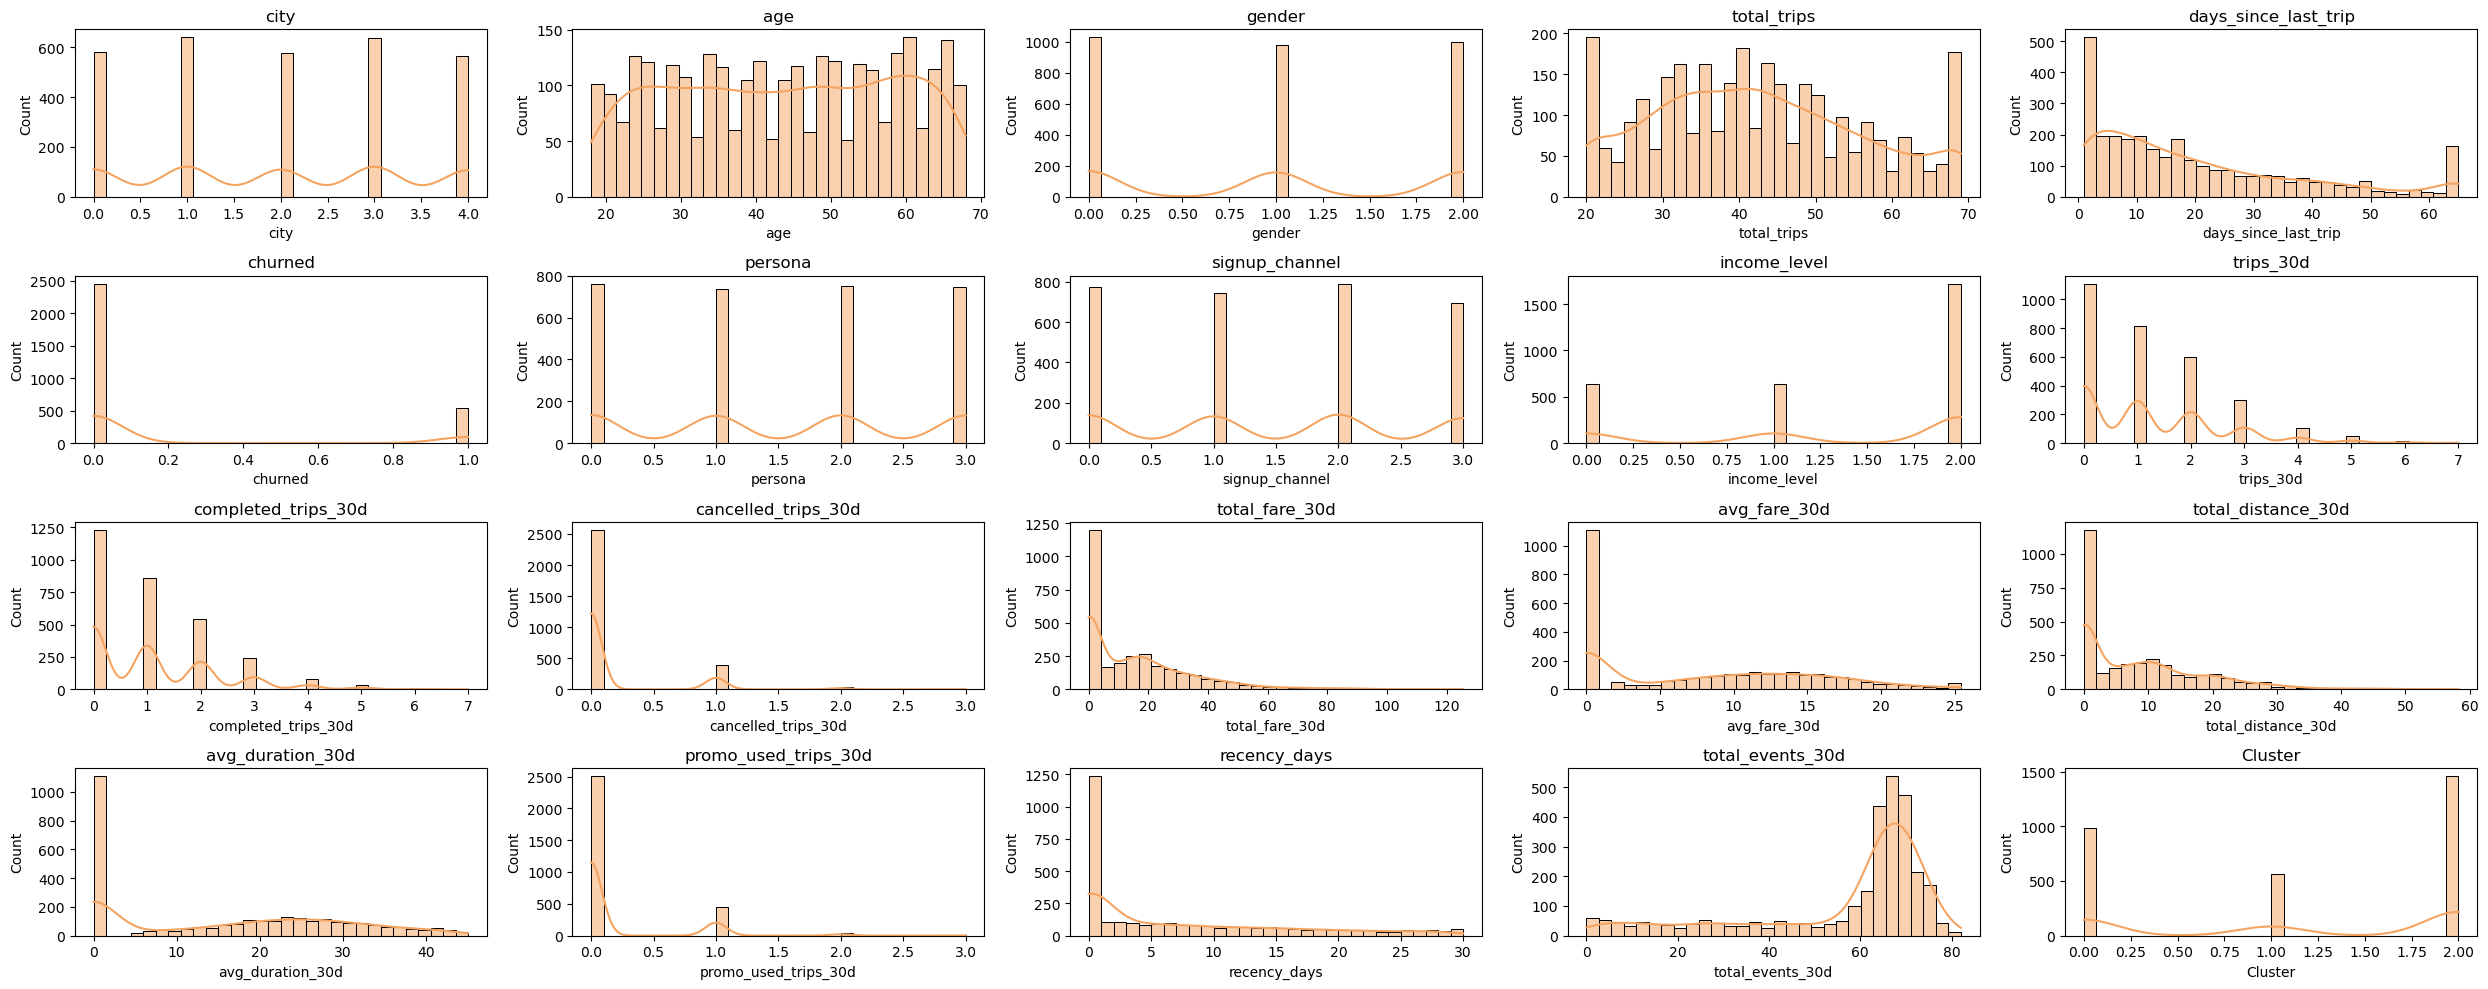

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 10))
ax = ax.flatten()

for idx, col in enumerate(model_df):
    sns.histplot(model_df[col], ax=ax[idx], color="Sandybrown", bins=30, kde=True)
    ax[idx].set_title(col)

plt.tight_layout()
plt.show()

##### Scaling numerical features

In [11]:
from sklearn.preprocessing import RobustScaler

In [12]:
scaler = RobustScaler()
num_cols_to_scale = ['age', 'total_trips', 'days_since_last_trip',
       'churned', 'trips_30d','completed_trips_30d', 'cancelled_trips_30d', 'total_fare_30d',
       'avg_fare_30d', 'total_distance_30d', 'avg_duration_30d',
       'promo_used_trips_30d', 'recency_days', 'total_events_30d', 'Cluster']
model_df[num_cols_to_scale] = scaler.fit_transform(model_df[num_cols_to_scale])

###### check class distribution

In [13]:
model_df["churned"].value_counts()

churned
0.0    2453
1.0     547
Name: count, dtype: int64

In [14]:
model_df["churned"].value_counts(normalize=True)*100

churned
0.0    81.766667
1.0    18.233333
Name: proportion, dtype: float64

<Axes: xlabel='churned', ylabel='count'>

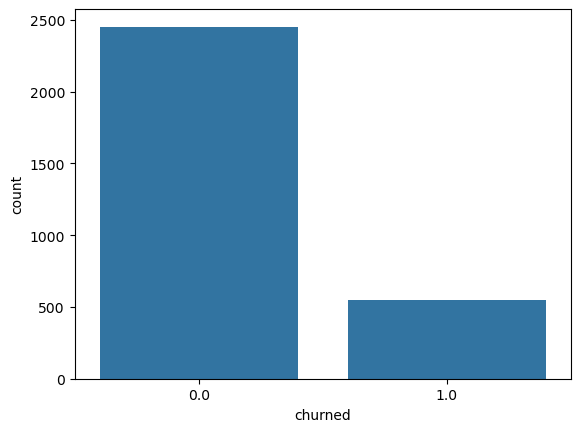

In [15]:
sns.countplot(x=model_df["churned"])

##### Handling Class Imbalance
###### Oversambling with SMOTE


In [16]:
from imblearn.over_sampling import SMOTE

# Seperate features and target
X = model_df.drop("churned", axis=1)
y = model_df["churned"]

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

churned
0.0    2453
1.0    2453
Name: count, dtype: int64

###### Convert the cleaned data back to dataframe

In [17]:
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df.head(3)

,city,age,gender,total_trips,days_since_last_trip,persona,signup_channel,income_level,trips_30d,completed_trips_30d,cancelled_trips_30d,total_fare_30d,avg_fare_30d,total_distance_30d,avg_duration_30d,promo_used_trips_30d,recency_days,total_events_30d,Cluster
0,3,-0.961538,2,1.10,0.208333,3,0,0,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.157895,-0.5
1,2,-0.692308,2,0.20,1.208333,0,3,2,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.105263,-0.5
2,4,0.038462,1,-0.65,-0.458333,0,3,2,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.052632,-0.5


In [18]:
resampled_df["churned"] = y_resampled
resampled_df.head(3)

,city,age,gender,total_trips,days_since_last_trip,persona,signup_channel,income_level,trips_30d,completed_trips_30d,cancelled_trips_30d,total_fare_30d,avg_fare_30d,total_distance_30d,avg_duration_30d,promo_used_trips_30d,recency_days,total_events_30d,Cluster,churned
0,3,-0.961538,2,1.10,0.208333,3,0,0,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.157895,-0.5,0.0
1,2,-0.692308,2,0.20,1.208333,0,3,2,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.105263,-0.5,0.0
2,4,0.038462,1,-0.65,-0.458333,0,3,2,-0.5,-0.5,0.0,-0.454536,-0.571174,-0.460395,-0.620438,0.0,-0.230769,-0.052632,-0.5,0.0


###### save resampled data

In [19]:
resampled_df.to_csv('../data/processed/cleaned_churn_balanced.csv', index=False)

##### Data splitting

In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 3434
Testing set size: 1472


In [21]:
# Proportion of Train set distribution
y_train.value_counts(normalize=True)*100

churned
1.0    50.49505
0.0    49.50495
Name: proportion, dtype: float64

In [22]:
# Proportion of Test set distribution
y_test.value_counts(normalize=True)*100

churned
0.0    51.154891
1.0    48.845109
Name: proportion, dtype: float64

#### Model selection
##### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [33]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_probability = logreg.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("Logistic Regression")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")


Logistic Regression
ROC-AUC: 0.635
F1-score: 0.572
Precision@15%: 0.691


##### Insight
The Logistic Regression model shows limited ability to rank and identify churners, making it suitable only as a baseline and not reliable enough for precise or high-value retention targeting.

##### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [35]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_probability = rf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("\nRandom Forest")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")



Random Forest
ROC-AUC: 0.930
F1-score: 0.853
Precision@15%: 0.986


##### Insight
The Random Forest model demonstrates excellent predictive performance, with strong ranking ability (ROC-AUC 0.93) and highly effective churn targeting. Nearly all customers identified in the top 15% risk segment are true churners, making the model well-suited for cost-efficient retention strategies.

##### Xgboost

In [36]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [37]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_probability = xgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("\nXGBoost")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")



XGBoost
ROC-AUC: 0.913
F1-score: 0.835
Precision@15%: 1.000


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##### Insight
The XGBoost model delivers excellent churn prediction performance, accurately ranking customers by risk and perfectly identifying churners within the top 15% highest-risk group, making it highly effective for targeted retention actions.

######